In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os 
import math
np.random.seed(1234)

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x+0.5))

def psigmoid(x):
    a = sigmoid(x)
    return a*(1 - a)

def ppsigmoid(x):
    a = sigmoid(x)
    return a - 3*a**2 + 2*a**3

def LeapFct(X,sets,coefs):
    p_sets = len(sets)
    parities = np.zeros((X.shape[0],p_sets))
    for j in range(p_sets):
        curr = np.ones(X.shape[0])
        for s in range(len(sets[j])):
            curr = curr*X[:,sets[j][s]]
        parities[:,j] = curr*coefs[j]
    return np.sum(parities,axis = 1)/ p_sets

def SquaredLoss(ytest,yhat_test):
    return np.mean((ytest - yhat_test)**2)

def randomRademacher(n,d):
    return 2*np.random.randint(2, size=(n,d))-1

def randomSecondLayer(N):
    return np.random.uniform(-1,1,N)

In [3]:
def smooth(v,ll):
    if ll == 0:
        return v
    ss = len(v)
    rr = np.copy(v)
    for i in range(ss):
        rr[i] = np.mean(v[max(0,i -ll):min(ss,i+ll)])
    return rr

In [4]:
def loss_train(y,f):
    return (y - f)**2 + (y - f)**3 +(y-f)**4

def loss_derivative(y,f):
    return 2*(y - f) + 3*(y - f)**2 + 4*(y-f)**3

def loss1_train(y,f):
    return (y - f)**2 + np.abs(y - f)**3 

def loss1_derivative(y,f):
    return 2*(y - f) + 3*np.sign(y-f)*(y - f)**2 

def squared_loss(y,f):
    return (y-f)**2

def squared_loss_derivative(y,f):
  return 2*(y-f)

def loss_ellone(y,f):
    return np.abs(y-f)

def loss_ellone_derivative(y,f):
    return np.sign(y-f)

In [5]:
def NNevaluation(W,a,X,N):
    Z = np.matmul(X,W.transpose())
    sigZ = sigmoid(Z)
    return np.matmul(sigZ,a)/N

def EvalError(W,a,mtest,N,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    ytest = LeapFct(Xtest,sets,coefs)
    yhat_test = NNevaluation(W,a,Xtest,N)
    return SquaredLoss(ytest,yhat_test)

def gradient_sq_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, squared_loss_derivative(ytrain,yMF))/mtrain]

def gradient_ellone_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss_ellone_derivative(ytrain,yMF))/mtrain]

def gradient_loss1(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss1_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss1_derivative(ytrain,yMF))/mtrain]


def evaluateFourierCoeff(W,a,N,mtest,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    yMF = NNevaluation(W,a,Xtest,N)
    p_sets = len(sets)
    parities = np.zeros((mtest,p_sets))
    for j in range(p_sets):
        curr = np.ones(mtest)
        for s in range(len(sets[j])):
            curr = curr*Xtest[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/mtest

In [6]:
def createXtot(P):
    Xtot = np.zeros((2**P,P))
    for i in range(2**P):
        Xtot[i,:] = np.array(list(np.binary_repr(i, width=P)))
    return 2*Xtot-1

In [7]:
def pexMSPEvalError(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    ytest = LeapFct(Xtot,sets,coefs)
    yhat_test = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return SquaredLoss(ytest,yhat_test)

def pexMSPNNevaluation(U,a,s,Xtot,mx,Nu,mG):
    G = np.random.normal(0,1,mG)
    Z = np.matmul(Xtot,U.transpose()).reshape(mx,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((mx,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2)
    return np.matmul(sigZ,a)/Nu

def pexMSPgradientloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientsqloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,squared_loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, squared_loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientloss1(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss1_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss1_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss1_derivative(ytrain,yMF))/2**P]

def pexMSPgradientlossellone(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_ellone_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_ellone_derivative(ytrain,yMF))/2**P]

def pexMSPevaluateFourierCoeff(U,a,s,Xtot,mG,Nu,P,sets,coefs):
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    p_sets = len(sets)
    parities = np.zeros((2**P,p_sets))
    for j in range(p_sets):
        curr = np.ones(2**P)
        for s in range(len(sets[j])):
            curr = curr*Xtot[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/2**P

In [8]:
P = 4
uuu = [[1,2,3],[0,2,3],[0,1,3],[0,1,2]]
ccc=np.random.uniform(-2,2,len(uuu))
print(ccc)
mmm = len(uuu)
KK=10
T=10
#T=4000

[-1.2339222   0.48843508 -0.24908904  1.14143433]


In [9]:
d = 100
xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF11 = np.zeros((KK,T))

TrackLossSGD11 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD11[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_ellone_loss(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF11[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientlossellone(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        
        print(kk,t, TrackLossDF11[kk,t], TrackLossSGD11[kk,t])

0 0 0.19541712235657352 0.20766236877122027
0 1 0.19541971122203317 0.21372598716594604
0 2 0.19545628327380138 0.19742817852818648
0 3 0.1954955556435339 0.21708555561621884
0 4 0.1955819455459183 0.20500515174958303
0 5 0.19565542096716693 0.18730680996169455
0 6 0.19582880619331616 0.20385024847254607
0 7 0.19593862643208496 0.21340202298789848
0 8 0.19620177431532015 0.1913144334202154
0 9 0.19641086471526303 0.20462490400183844
1 0 0.19544907333846917 0.19112401676309246
1 1 0.1954478277521839 0.19649568937278136
1 2 0.19548053441161864 0.20691645311428383
1 3 0.19553508133815675 0.1897809367329955
1 4 0.1955979709094759 0.1986742738294366
1 5 0.19570269904736964 0.20619187926246027
1 6 0.19584935375592807 0.20067631217812343
1 7 0.19597049849243695 0.19743453138180966
1 8 0.19622714527160728 0.1890983636305104
1 9 0.19636908942614 0.21355111551303768
2 0 0.19628787075255 0.19360576246976965
2 1 0.19639180133796083 0.18849188578164128
2 2 0.1964577202206512 0.18713464054376414
2 3

In [10]:
d =300

xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF12 = np.zeros((KK,T))
TrackLossSGD12 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD12[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_ellone_loss(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF12[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientlossellone(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        
        print(kk,t,TrackLossDF12[kk,t], TrackLossSGD12[kk,t])

0 0 0.19654822271106498 0.19782942671615678
0 1 0.196433906428231 0.20849739511569548
0 2 0.1967634643927756 0.19065631270944958
0 3 0.19599422685494525 0.21802931278457877
0 4 0.19610802210400416 0.1902591576825101
0 5 0.1961566376562991 0.17549796906191864
0 6 0.19629089696722302 0.18857629472347484
0 7 0.19602099805229178 0.19922065744182155
0 8 0.1962491769456423 0.21061518719105307
0 9 0.19640549746414293 0.20793312805411748
1 0 0.19553901867536536 0.21213163214389097
1 1 0.1955681509024449 0.17477333941535947
1 2 0.1955880501021841 0.19783179564905098
1 3 0.19564292590008509 0.1868079513321566
1 4 0.1957431295113149 0.18055319463337172
1 5 0.19587904023041225 0.17034997212019154
1 6 0.1960816190372468 0.20018705045601567
1 7 0.19623068705745206 0.19680912395067074
1 8 0.196213724826725 0.233425115219546
1 9 0.19652851859897003 0.1983674346759325
2 0 0.1978642396116278 0.18676100911928978
2 1 0.19666822274219087 0.1632696253214615
2 2 0.1961989762725551 0.18945613449350243
2 3 0.1

In [11]:
d = 500

xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF13 = np.zeros((KK,T))

TrackLossSGD13 = np.zeros((KK,T))
#TrackFourierSGD13 = np.zeros((KK,T,mmm))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD13[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_ellone_loss(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF13[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        #TrackFourierDF13[kk,t,:] = pexMSPevaluateFourierCoeff(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu)
    
        [GUDF,GaDF,GsDF] = pexMSPgradientlossellone(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        
        print(kk,t,TrackLossDF13[kk,t], TrackLossSGD13[kk,t])

0 0 0.19566715465594642 0.21748535956923504
0 1 0.19566506361586683 0.20393833321535235
0 2 0.19563477174376365 0.21172476632495577
0 3 0.19577155097669813 0.19019478237066703
0 4 0.19580061512797686 0.19241961931893467
0 5 0.19591126564747557 0.17662776433499772
0 6 0.19611017564608024 0.19830750705870762
0 7 0.19586173312460955 0.19997528351975546
0 8 0.19610414630109757 0.1967097023360233
0 9 0.1963011886310178 0.1741209090076908
1 0 0.20094805596471046 0.20129829546465292
1 1 0.19981761602409037 0.19197543224566935
1 2 0.19911027926170188 0.19735454025426036
1 3 0.1982912607325113 0.18818212260195047
1 4 0.19724524521784514 0.19257012935215798
1 5 0.19707040724635444 0.177717244363967
1 6 0.19671735092699985 0.19968216803729363
1 7 0.19633300535610346 0.18426954509104793
1 8 0.19660923349413983 0.21651812757402994
1 9 0.19671292015783448 0.21495388561033796
2 0 0.19539829725831936 0.20245168944368108
2 1 0.19540713582391955 0.1959552434223193
2 2 0.19543520360230032 0.1812922599796

In [12]:
meanLossDF11 =  np.mean(TrackLossDF11,axis = 0)

meanLoss11 = np.mean(TrackLossSGD11,axis = 0)
stdLoss11 = np.std(TrackLossSGD11,axis = 0)/np.sqrt(KK)


In [13]:
meanLossDF12 =  np.mean(TrackLossDF12,axis = 0)

meanLoss12 = np.mean(TrackLossSGD12,axis = 0)
stdLoss12 = np.std(TrackLossSGD12,axis = 0)/np.sqrt(KK)


In [14]:
meanLossDF13 = np.mean(TrackLossDF13,axis = 0)

meanLoss13 = np.mean(TrackLossSGD13,axis = 0)
stdLoss13 = np.std(TrackLossSGD13,axis = 0)/np.sqrt(KK)

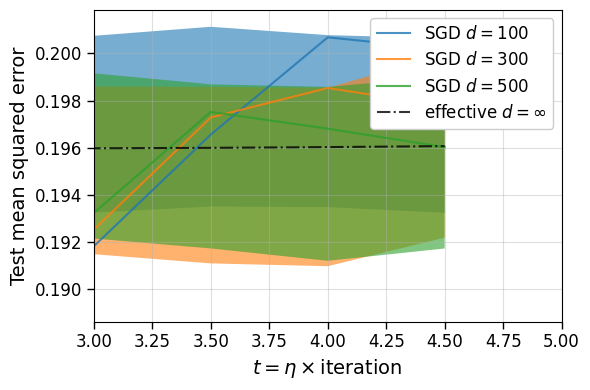

In [15]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})


ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)


   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label='effective $d=\infty$')

ax.grid(alpha=0.4)
ax.set_xlabel(r'$t= \eta \times $iteration', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.legend(loc='upper right', fontsize=12, framealpha = 1)
#ax.set_xscale('log')
ax.set_xlim([3,xi*T])





fig.tight_layout()
plt.savefig('ell1loss/ell1leap1.pdf')
plt.show()

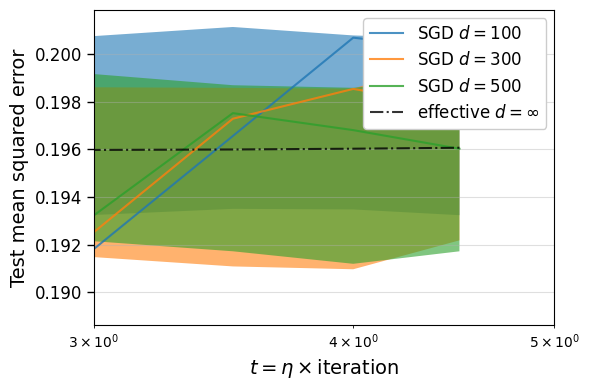

In [16]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})


ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)


   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label='effective $d=\infty$')

ax.grid(alpha=0.4)
ax.set_xlabel(r'$t= \eta \times $iteration', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.legend(loc='upper right', fontsize=12, framealpha = 1)
ax.set_xscale('log')
ax.set_xlim([3,xi*T])





fig.tight_layout()
plt.savefig('ell1loss/ell1leap1-log.pdf')
plt.show()